# Simple Recurrent Neural Network (RNN)

Although PyTorch has built in functions and classes for implementing RNNs, I would like to implement it with PyTorch without using such functions. For starters, let's start with the base architecture of a RNN illustrated below:

```mermaid
graph TD
    subgraph "t=0"
        x0[Input x₀]
        h0[Hidden state h₀]
        y0[Output y₀]
        
        x0 -->|Wx| sumH0((+))
        sumH0 -->|"+ bh"| actH0["tanh()"]
        actH0 --> h0
        
        h0 -->|Wy| sumY0((+))
        sumY0 -->|"+ by"| y0
    end
    
    subgraph "t=1"
        x1[Input x₁]
        h1[Hidden state h₁]
        y1[Output y₁]
        
        x1 -->|Wx| sumH1((+))
        h0 -->|Wh| sumH1
        sumH1 -->|"+ bh"| actH1["tanh()"]
        actH1 --> h1
        
        h1 -->|Wy| sumY1((+))
        sumY1 -->|"+ by"| y1
    end
    
    subgraph "t=2"
        x2[Input x₂]
        h2[Hidden state h₂]
        y2[Output y₂]
        
        x2 -->|Wx| sumH2((+))
        h1 -->|Wh| sumH2
        sumH2 -->|"+ bh"| actH2["tanh()"]
        actH2 --> h2
        
        h2 -->|Wy| sumY2((+))
        sumY2 -->|"+ by"| y2
    end
    
    classDef input fill:#D6EAF8
    classDef hidden fill:#D5F5E3
    classDef output fill:#FADBD8
    classDef operation fill:#F9E79F
    
    class x0,x1,x2 input
    class h0,h1,h2,h0prev hidden
    class y0,y1,y2 output
    class sumH0,sumH1,sumH2,sumY0,sumY1,sumY2,actH0,actH1,actH2,actY0,actY1,actY2 operation
```

In [ ]:
# Model specification (architecture) of a simple RNN with no stack for a vector

import torch
from torch import nn

class SimpleScratchRNN(nn.Module):
    def __init__(self):
        super(SimpleScratchRNN, self).__init__()

        self.W_x = nn.Parameter( #need to ensure dtype=torch.float32 to work with nn.MSELoss() 
            torch.randn(1, 1, requires_grad=True, dtype=torch.float32) * 0.01
        )
        self.W_h = nn.Parameter(
            torch.randn(1, 1, requires_grad=True, dtype=torch.float32) * 0.01
        )
        self.b_h = nn.Parameter(
            torch.zeros(1, requires_grad=True, dtype=torch.float32) 
        )

        self.W_y = nn.Parameter(
            torch.randn(1, 1, requires_grad=True, dtype=torch.float32) * 0.01
        )
        self.b_y = nn.Parameter(
            torch.zeros(1, requires_grad=True, dtype=torch.float32)
        )
        

    def forward(self, x, h_0 = None):
        batch_size = x.size()[0]

        if h_0 is None:
            h_0 = torch.zeros(batch_size, 1, dtype=torch.float32) #set initial hidden state to 0

        h_t = h_0 #inherit hidden state from previous step

        output = torch.zeros(batch_size, 1)

        #get input at current time step
        x_t = x.to(dtype=torch.float32)

        h_t = torch.tanh( #tanh is the activation function
            x_t @ self.W_x + h_t @ self.W_h + self.b_h
        )

        y_t = h_t @ self.W_y + self.b_y #conpute output

        output = y_t
        
        return output, h_t

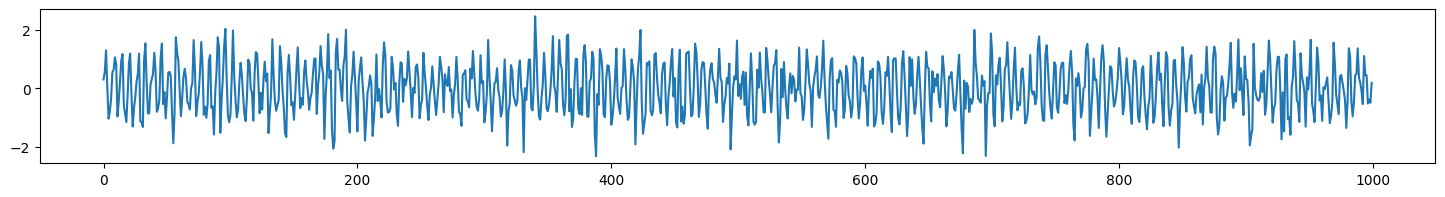

In [85]:
# Simulate data (sine wave + r.v. from N(0,1))

import numpy as np
import matplotlib.pyplot as plt

index = np.array(range(0, 1000))
data_series = np.sin(index) + np.random.normal(0, 0.5, size=len(index))

plt.subplots(figsize=(18,2))
plt.plot(index, data_series)

index = torch.FloatTensor(index)
mock_data = torch.FloatTensor(data_series)

plt.show()


In [86]:
# Prepare dataset for training

def train_test_split(data, sequence_length=1, train_split=0.8):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+1:i+sequence_length+1])  # Next value for each position

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    X = X.reshape(-1, sequence_length, 1)
    y = y.reshape(-1, sequence_length, 1)

    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(data=data_series)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [ ]:
# Train Model
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Setup hyperparamters
batch_size = 50
epochs = 100
learning_rate = 0.001

# Preprocess dataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Setup model
model = SimpleScratchRNN()

# Setup loss function and optimizer
criterion = nn.MSELoss() #there is no RMSE
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train()
    for batch_id, (data, target) in enumerate(train_loader): #for each batch, also get the index of batch
        optimizer.zero_grad()
        output, _ = model(data) #forward pass
        loss = criterion(output, target)
        loss.backward() #compute gradients
        optimizer.step() #update weights
        
        total_loss += loss.item()

        if batch_id % 20 == 0 and epoch % 20 == 0: #update on training iterations
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_id * len(data), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.item()))

/home/tony/anaconda3/envs/rec-sys/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/tony/anaconda3/envs/rec-sys/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([49, 1, 1])) that is different to the input size (torch.Size([49, 49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 20 [0/799 (0%)]	Loss: 0.813714
Train Epoch: 40 [0/799 (0%)]	Loss: 0.541391
Train Epoch: 60 [0/799 (0%)]	Loss: 0.793827
Train Epoch: 80 [0/799 (0%)]	Loss: 0.811043
Train Epoch: 100 [0/799 (0%)]	Loss: 0.878973
